# Choosing the right Modle
In this notebook i will predict the stockprice using several models in order to find the best fitting one


## Setup

In [25]:
import math
from matplotlib import gridspec
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM 
import matplotlib as mpl
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow import keras

import tensorflow as tf
from alpha_vantage.fundamentaldata import FundamentalData
from alpha_vantage.timeseries import TimeSeries
from datetime import *
plt.tight_layout()

Stock = "AAPL"
API_KEY = "2K412SNOUGH30X5E"
observation_time = 60
future_time = 1
training_start_date = datetime(2015, 10, 1)
training_end_date = datetime(2020, 1, 1)

# Percent of set
training_set_size = 64/100;
validation_set_size = 16/100;
test_set_size = 20/100

feature_size = 60

<Figure size 432x288 with 0 Axes>

# Testing the Model
Add a posibility to test how good the modle would fit for fourcasting

In [43]:
class StockManager:
    def __init__(self, my_money):
        self.my_money = my_money
        self.my_inital_money = my_money
        self.amount_of_stocks = 0
        # the money that was used to buy a stock (was risked to lose it...)
    
    def buy_stock(self, current_stock_price):
        number_of_stocks_to_buy = int(self.my_money / current_stock_price)
        self.my_money = self.my_money - (current_stock_price * number_of_stocks_to_buy)
        self.amount_of_stocks = self.amount_of_stocks + number_of_stocks_to_buy

    def reset(self):
        self.my_money = self.my_inital_money
        self.amount_of_stocks = 0
  

    def sell_stock(self, current_stock_price):
        self.my_money = self.my_money + self.amount_of_stocks * current_stock_price
        self.amount_of_stocks = 0
            
    def get_current_winnings(self, current_stock_price):
        return self.my_money + self.amount_of_stocks * current_stock_price - self.my_inital_money
    
    
    def get_current_winnings_in_percent(self, current_stock_price):
        if (self.invested_money == 0):
            return 0
        return self.get_current_winnings(current_stock_price)/self.invested_money

class HistoryMangaer:
    def __init__(self, labels=[]):
        self.reset()
        self.labels = labels
        
    def reset(self):
        self.winnings = []
        self.amount_of_stocks = []
        self.time = []
        self.stock_price = []
        self.buy_time_x = []
        self.buy_time_y = []
        self.sell_time_x = []
        self.sell_time_y = []
        self.params = {}
        self.winning_trades = 0
        self.loosing_trades = 0
    
    def add_point_in_history(self, stock_manager, time, current_stock_price, **params):
        datapoints = len(self.amount_of_stocks)
        if ( datapoints > 0 ):
            if (stock_manager.amount_of_stocks > self.amount_of_stocks[datapoints-1] ):
                self.buy_time_x.append(time)
                self.buy_time_y.append(current_stock_price)
            if (stock_manager.amount_of_stocks < self.amount_of_stocks[datapoints-1] ):
                self.sell_time_x.append(time)
                self.sell_time_y.append(current_stock_price)
                if len(self.buy_time_y) > 0:
                    if current_stock_price > self.buy_time_y[-1]:
                        self.winning_trades += 1
                    else:
                        self.loosing_trades += 1
        for key, value in params.items():
            if not key in self.params:
                self.params[key] = [value]
            else:
                self.params[key].append(value)
            
        self.winnings.append(stock_manager.get_current_winnings(current_stock_price) +  stock_manager.my_inital_money)
        self.amount_of_stocks.append(stock_manager.amount_of_stocks)
        self.stock_price.append(current_stock_price)
        self.time.append(time)
        
    def get_sharpe_ratio(self,data):
        if len(self.buy_time_x) == 0:
            return 0
        R = pd.DataFrame(data)
        r = R.diff()
        sr = r.mean()-0.000168/(R.pct_change().std() * np.sqrt(252))
        number_of_periodes = len(r)/252
        winnings = data[-1]/data[0]
        cagr = pow(winnings,1/number_of_periodes)-1 
        risk_free_rate = 0.02
        annual_volatility = float(R.pct_change().std() * np.sqrt(252))
        if annual_volatility < float(0.001):
            annual_volatility = 0.001
        sr = (cagr-risk_free_rate)/(annual_volatility)
        return sr
        
        
    def plot_history(self):
        plt.figure(figsize=(18,9))
        labels = self.time
        
        number_of_periodes = len(self.winnings)/252
        w = self.winnings[-1]/self.winnings[0]
        w_s = self.stock_price[-1]/self.stock_price[0]
        anual_return = pow(w,1/number_of_periodes)-1 
        anual_return_s = pow(w_s,1/number_of_periodes)-1 
        
        print("\"Sharp Ratio Strategy\";\"Anual return\";\"Winning trades\";\"Loosing trades\"")
        print("\""+str(float(self.get_sharpe_ratio(self.winnings)))+"\";\""+str(anual_return)+"\";\""+str(self.winning_trades)+"\";\""+str(self.loosing_trades)+"\"")

        if len(self.labels) > 0:
            labels = self.labels[:len(self.time)]
        if True:
            plt.plot(labels, self.stock_price, ".-", label="Adjusted closing price")
            plt.plot(labels, self.winnings, ".-", label="Winnings")
            plt.plot(self.buy_time_x, self.buy_time_y, 'o',color='#00FF00',label="Buy")
            plt.plot(self.sell_time_x, self.sell_time_y, 'o',color='#FF0000',label="Sell")
            plt.xlabel("Date")
            plt.ylabel("Closing Price")

            for key in self.params:

                sumi = 0
                sum_of_data = []
                for data_sumi in self.params[key]:
                    sumi = sumi + data_sumi
                    sum_of_data.append(sumi)     

                plt.plot(labels, self.params[key], ".-", label=key, color='#CCCCCC')
                plt.plot(labels, sum_of_data, ".-", label=key, color='#FFCCCC')

            plt.legend(fontsize=14)
            plt.legend(fontsize=14)
            plt.grid(b=True, which='major',color='#CCCCCC')
            plt.minorticks_on()
            plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
            plt.show()
        return [float(self.get_sharpe_ratio(self.winnings)),anual_return]
        
class DataManager:
    def __init__(self, stock_symbol, end_date, start_date="", scale=False):
        self.stock_symbol = stock_symbol
        self.end_date = end_date
        self.start_date = start_date
        self.scale = scale
        self.scale_factor = 1
        self.unscaled_data = None
        self.getting_data()
        self.scaler = MinMaxScaler(feature_range=(0,1))
        
    def getting_data(self):
        ts = TimeSeries(key=API_KEY, output_format='pandas')
        self.raw_stock_data, meta_data = ts.get_daily_adjusted(symbol=self.stock_symbol, outputsize='full')
        if self.start_date == "":
            self.raw_stock_data = self.raw_stock_data.loc[self.end_date:]
        else:
            self.raw_stock_data = self.raw_stock_data.loc[self.end_date:self.start_date]
        

        adjusted_close_data = self.raw_stock_data.filter(["5. adjusted close"]).values
        adjusted_close_data = np.flip(adjusted_close_data)
        open_data = self.raw_stock_data.filter(["1. open"]).values
        open_data = np.flip(open_data)
        low_data = self.raw_stock_data.filter(["3. low"]).values
        low_data = np.flip(low_data)
        high_data = self.raw_stock_data.filter(["2. high"]).values
        high_data = np.flip(high_data)
        close_data = self.raw_stock_data.filter(["4. close"]).values
        close_data = np.flip(close_data)
        
        vol_data = self.raw_stock_data.filter(["6. volume"]).values
        vol_data = np.flip(close_data)
        
        self.date_key = np.flip(self.raw_stock_data["5. adjusted close"].keys())
        tmp_data = []
        unscaled_tmp_data = []
        
        if (self.scale):
            for i in range(0, len(open_data)):
                adjusted_factor = adjusted_close_data[i][0] / close_data[i][0]
                self.scale_factor = max(self.scale_factor,high_data[i][0]* adjusted_factor)
    
        for i in range(0, len(open_data)):
            adjusted_factor = adjusted_close_data[i][0] / close_data[i][0]
            unscaled_tmp_data.append({
                "open": (open_data[i][0] * adjusted_factor),
                "adjusted_close": (adjusted_close_data[i][0]),
                "close": (close_data[i][0] * adjusted_factor),
                "high": (high_data[i][0]* adjusted_factor),
                "low": (low_data[i][0] * adjusted_factor),
                "data": self.date_key[i],
                "vol": vol_data[i][0]
            })
            tmp_data.append({
                "open": (open_data[i][0] * adjusted_factor)/self.scale_factor,
                "adjusted_close": (adjusted_close_data[i][0])/self.scale_factor,
                "close": (close_data[i][0] * adjusted_factor)/self.scale_factor,
                "high": (high_data[i][0]* adjusted_factor)/self.scale_factor,
                "low": (low_data[i][0] * adjusted_factor)/self.scale_factor,
                "data": self.date_key[i],
                "vol": vol_data[i][0]
            })

        self.raw_stock_data = tmp_data
        self.unscaled_data = unscaled_tmp_data
        
    def rescale(self, factor):
        self.scale_factor = factor
        tmp_data = []
        for i in range(0, len(self.unscaled_data)):
            tmp_data.append({
                "open": self.unscaled_data[i]["open"]/factor,
                "adjusted_close": self.unscaled_data[i]["open"]/factor,
                "close": self.unscaled_data[i]["open"]/factor,
                "high": self.unscaled_data[i]["open"]/factor,
                "low": self.unscaled_data[i]["open"]/factor,
                "data": self.unscaled_data[i]["data"],
                "vol": self.unscaled_data[i]["vol"],
            })
        self.raw_stock_data = tmp_data

        
class TradeMaker:
    def __init__(self, stock_symbol, money,  end_date, start_date="", start_day=0, scale = False):
        self.data_manager = DataManager(stock_symbol, end_date, start_date,scale)
        self.manager_number = 0
        self.start_day = start_day
        self.current_day = start_day
        self.max_number_of_days = len(self.data_manager.raw_stock_data)
        self.date_keys = self.data_manager.date_key[start_day:]
        self.history_manager = HistoryMangaer(self.date_keys)
        self.stock_manager = StockManager(money)
        self.stop_market_order_price = 0
        self.stop_market_order_amount = 0
        self.active_stop_market_order = False
        self.last_buy_price = 0
        
    def reset(self):
        self.current_day = self.start_day
        self.max_number_of_days = len(self.data_manager.raw_stock_data)
        self.stop_market_order_price = 0
        self.stop_market_order_amount = 0
        self.active_stop_market_order = False
        self.last_buy_price = 0
        
        
    def is_invested(self):
        return self.stock_manager.amount_of_stocks != 0
        
    def get_historical_data(self, days, price_type):
        data = self.data_manager.raw_stock_data[max(self.current_day-days,0):self.current_day]
        return_value = []
        for prices in data:
            return_value.append(prices[price_type])
        return return_value
        
            
    def current_date(self):
        return self.data_manager.date_key[self.current_day]
        
        
    def stop_market_order(self, price, amount=0):
        self.stop_market_order_price = price
        self.stop_market_order_amount = amount
        self.active_stop_market_order = True

    def cancel_stop_market_order(self):
        self.active_stop_market_order = False
        
    def next_day(self, **params):
        # Check the pending stop marked orders
        if self.active_stop_market_order:
            low = self.data_manager.raw_stock_data[self.current_day]["low"]
            high = self.data_manager.raw_stock_data[self.current_day]["high"]
            
            
            if self.stop_market_order_price > low and self.stop_market_order_price < high:
                self.stock_manager.sell_stock(self.stop_market_order_price)
                self.active_stop_market_order = False

        self.history_manager.add_point_in_history(self.stock_manager,self.current_date(),self.todays_price()["close"],**params)
        yesterdays_close = self.todays_price()["close"]
        if ( self.current_day >= self.max_number_of_days - 1 and self.is_invested() ):
            self.sell()
        self.current_day += 1
        done = False
        if ( self.current_day >= self.max_number_of_days ):
            done = True
        elif(self.active_stop_market_order == True):
            today_open = self.todays_price()["open"]
            if self.stop_market_order_price > min(today_open,yesterdays_close) and self.stop_market_order_price < max(today_open,yesterdays_close):
                self.stock_manager.sell_stock(self.stop_market_order_price)
                self.active_stop_market_order = False
        return done
        
    def todays_price(self):
        return self.data_manager.raw_stock_data[self.current_day]
    
    def buy(self):
        self.stock_manager.buy_stock(self.todays_price()["open"])
        self.last_buy_price = self.todays_price()["open"]

    def sell(self):
        self.stock_manager.sell_stock(self.todays_price()["open"])
        
    
    def plot(self):
        return self.history_manager.plot_history()

    def winnings(self):
        return self.stock_manager.get_current_winnings(self.todays_price()["open"])
    
    def stock_increasement(self):
        return (self.todays_price()["open"] - self.history_manager.stock_price[0])/self.history_manager.stock_price[0]
    
    def get_current_winnings_in_percent(self):
        return self.stock_manager.get_current_winnings_in_percent(self.todays_price()["open"])
    
    def get_reward(self):
        if (len(self.history_manager.sell_time_x) > 0 and self.current_day > 0 and len(self.data_manager.date_key) > 0 and len(self.history_manager.buy_time_x) > 0 and self.history_manager.sell_time_x[-1] == self.data_manager.date_key[self.current_day-1]):
            return  (((self.history_manager.sell_time_y[-1]-0.0015) - self.history_manager.buy_time_y[-1])/self.history_manager.buy_time_y[-1])*8.0
        return 0
        




In [27]:
def get_current_features(t):
    ## calc RSI
    rsi_period = 14
    closing_prices = t.get_historical_data(rsi_period+1,"close")
    pos_profits = 0
    neg_profits = 0 
    for i in range(1,rsi_period+1):
        profit = (closing_prices[i]-closing_prices[i-1])/closing_prices[i]
        if ( profit > 0 ):
            pos_profits = pos_profits + profit
        else:
            neg_profits = neg_profits - profit
    
    pos_profits = pos_profits/rsi_period
    neg_profits = neg_profits/rsi_period
    rsi = pos_profits/(pos_profits+neg_profits)

    ## vol
    vol_period = 30
    vol_history = t.get_historical_data(vol_period+1,"vol")
    vol_in =  vol_history[-1] / np.mean(vol_history[-30:-1])
    
    ## close mean
    closing_prices = t.get_historical_data(27,"close")
    sma9 = np.mean(closing_prices[-9:])
    sma12 = np.mean(closing_prices[-12:])
    sma26 = np.mean(closing_prices[-26:])
    
    
    
    ## high values:
    highs = t.get_historical_data(40,"high")
    highest_high = max(highs[:-1])
    
    ## low values
    lows = t.get_historical_data(40,"low")
    lowest_lows = min(lows[:-1])
    
    invested_stocks = t.stock_manager.amount_of_stocks
    last_buy_price = t.last_buy_price
    opening_price_today = t.todays_price()["open"]
    return np.array([rsi,sma9,sma12,sma26,lowest_lows,highest_high,int(invested_stocks>0),last_buy_price,opening_price_today, (vol_in-1)*0.5+0.5])
  
def validate( t , model  ):
    done = False
    t.reset()
    t.history_manager.reset()
    t.stock_manager.reset()

    while done != True:
        obs = get_current_features(t)
        obs = np.array([[obs]])
        [[sell,nothing ,buy]] = model.predict(obs)
        if ( buy > sell and buy > nothing ):
            t.buy()
        elif ( sell > buy and sell > nothing ):
            t.sell()
        done = t.next_day()
  
    my_data = t.plot()
    t.current_day = 0
    t.history_manager.reset()
    t.stock_manager.reset()
    return my_data

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5068270020892093";"0.1062270879742766";"18";"10"


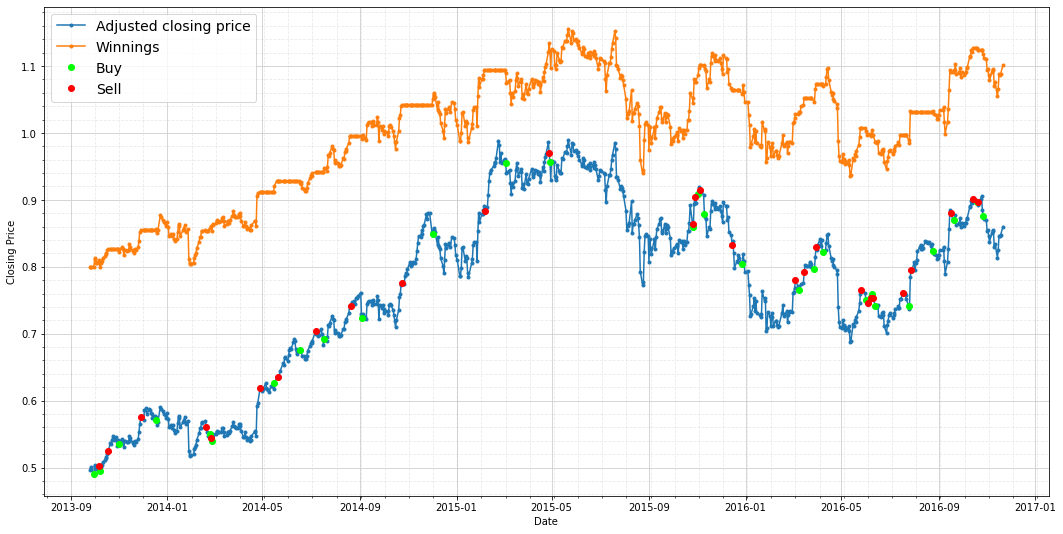

[0.5068270020892093, 0.1062270879742766]

In [44]:
stevie = keras.models.load_model("./steavie_test.huber.bad")
v_trader = TradeMaker("AAPL",0.8,"2016-11-21", "2013-06-27",62, True)
validate(v_trader,stevie)

In [29]:
def ai(t):
    return validate(t,stevie)

## Train Trading Agent

In [30]:

t = TradeMaker("KO",25,"2013-06-27", "1913-06-27",32)

## Momentum strategy 

### Breakout strategy

In [32]:
def breakout(t):
    done = False
    t.reset()
    t.history_manager.reset()
    t.stock_manager.reset()
    max_lookback = 40
    min_lookback = 20
    lookback = 30

    security_sell = 0.98
    security_sell_price = 0
    sell = 0.92
    highest_price = 0

    while done != True:
        closing_prices = t.get_historical_data(31,"close")
        volatility_today = np.std(closing_prices[1:31])
        volatility_yesterday = np.std(closing_prices[0:30])
        diff_v = (volatility_today - volatility_yesterday)/volatility_today
        lookback = min(max(int(round(lookback * (1 + diff_v))),min_lookback),max_lookback)
        highs = t.get_historical_data(lookback,"high")
        highest_high = max(highs[:-2])
        if not t.is_invested() and highest_high < closing_prices[-1]:
            t.buy()
            security_sell_price = t.todays_price()["open"] * security_sell
            t.stop_market_order(security_sell_price)
            highest_price = highest_high
        if t.is_invested() and closing_prices[-1] > highest_price:
            highest_price = closing_prices[-1]
            sell_price = closing_prices[-1] * sell
            if ( sell_price > security_sell_price ):
                t.stop_market_order(sell_price)


        done = t.next_day()

    my_data = t.plot()
    t.current_day = 0
    t.history_manager.reset()
    t.stock_manager.reset()
    return my_data

## MACD

In [33]:
def macd(t):
    done = False
    t.reset()
    t.history_manager.reset()
    t.stock_manager.reset()
    max_lookback = 40
    min_lookback = 20
    lookback = 30

    security_sell = 0.95
    security_sell_price = 0
    sell = 0.92
    highest_price = 0

    macd_array = []
    macd9_array = []
    diff_array = []
    has_crossed_from_above_to_below_zero_since_selling = True
    has_crossed_from_below_to_above_zero_since_buying = False
    buy_low = 0

    while done != True:
        closing_prices = t.get_historical_data(27,"close")
        sma9 = np.mean(closing_prices[-9:])
        sma12 = np.mean(closing_prices[-12:])
        sma26 = np.mean(closing_prices[-26:])

        sma12_y = np.mean(closing_prices[-13:-1])
        sma26_y = np.mean(closing_prices[-27:-1])

        macd = sma12 - sma26
        macd9 = 0
        if len(macd_array) > 9:
            macd9 = np.mean(macd_array[-9:])

        diff = macd - macd9
        diff_array.append(diff)
        if macd < 0 and  len(macd_array) > 1 and macd_array[-1] > 0:
            has_crossed_from_above_to_below_zero_since_selling = True
        elif macd > 0 and len(macd_array) > 1 and macd_array[-1] < 0:
            has_crossed_from_below_to_above_zero_since_buying = True
        macd_array.append(macd)
        macd9_array.append(macd9)
        macd_y = sma12_y - sma26_y
        if len(diff_array) > 2 and diff > 0: 
            if not t.is_invested() and has_crossed_from_above_to_below_zero_since_selling:
                t.buy()
                security_sell_price = t.todays_price()["open"] * security_sell
                has_crossed_from_below_to_above_zero_since_buying = False
                buy_low = macd
            if t.is_invested() and macd < buy_low:
                t.sell()
                has_crossed_from_above_to_below_zero_since_selling = False
                t.cancel_stop_market_order()
               # print("Stop-Loss")


        if t.is_invested()  and len(diff_array) > 2 and diff < 0 and has_crossed_from_below_to_above_zero_since_buying:
        #    if t.todays_price()["open"] > security_sell_price:
            t.sell()
            has_crossed_from_above_to_below_zero_since_selling = False
                #t.cancel_stop_market_order()
         #   else:
                ## try to come out wih less losses 
          #      t.stop_market_order(security_sell_price)
                #t.sell()
        done = t.next_day( )


    my_data = t.plot()
    t.current_day = 0
    t.history_manager.reset()
    t.stock_manager.reset()
    return my_data

#axs[2].show()

# Mean reverse 

## RSI

In [34]:
def rsi(t):
    done = False
    t.reset()
    t.history_manager.reset()
    t.stock_manager.reset()
    max_lookback = 40
    min_lookback = 20
    lookback = 30

    rsi_array = []

    security_sell = 0.98
    security_sell_price = 0
    sell = 0.92
    rsi_period = 14
    highest_price = 0

    while done != True:
        closing_prices = t.get_historical_data(rsi_period+1,"close")
        pos_profits = 0
        neg_profits = 0
        ## calc RSI 
        for i in range(1,rsi_period+1):
            profit = (closing_prices[i]-closing_prices[i-1])/closing_prices[i]
            if ( profit > 0 ):
                pos_profits = pos_profits + profit
            else:
                neg_profits = neg_profits - profit


        pos_profits = pos_profits/rsi_period
        neg_profits = neg_profits/rsi_period
        rsi = pos_profits/(pos_profits+neg_profits) * 100
        rsi_array.append(rsi)
        if not t.is_invested() and rsi < 30 :
            t.buy()
            security_sell_price = t.todays_price()["open"] * security_sell
           # t.stop_market_order(security_sell_price)
            highest_price = t.todays_price()["open"]
        if t.is_invested():
            if rsi > 70:
                t.sell()
                #t.cancel_stop_market_order()
            #if closing_prices[-1] > highest_price
            #    highest_price = closing_prices[-1]
            #    sell_price = closing_prices[-1] * sell
            #    if ( sell_price > security_sell_price ):
            #        t.stop_market_order(sell_price)


        done = t.next_day()

    my_data = t.plot()
    t.current_day = 0
    t.history_manager.reset()
    t.stock_manager.reset()
    return my_data
  
    #ax2.show()

In [35]:
import seaborn as sns

def plot_dis(ai, break_out, macd, rsi,scale_x,scale_y):
    plt.figure(figsize=(18,9))
    plt.subplot(2, 2, 1)

    sns.distplot(ai, hist=False, label='AI')
    plt.axvline(x=sum(ai) / len(ai), color="#444444")


    plt.axvline(x=-100, color="orange", label='Breakout')
    plt.axvline(x=-100, color="g", label='MACD')
    plt.axvline(x=-100, color="r", label='RSI')

    plt.legend(fontsize=14,  bbox_to_anchor=(0.3, 1, 0, 0))
    plt.grid(b=True, which='major',color='#CCCCCC')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    plt.xlim([scale_y*-1, scale_y])
    plt.ylim([0, scale_x])

  
    plt.subplot(2, 2, 2)


    sns.distplot(break_out, hist=False, color="orange")
    plt.axvline(x=sum(break_out) / len(break_out), color="#444444")


    plt.grid(b=True, which='major',color='#CCCCCC')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    plt.xlim([scale_y*-1, scale_y])
    plt.ylim([0, scale_x])


    plt.subplot(2, 2, 3)

    sns.distplot(macd, hist=False, color="g")
    plt.axvline(x=sum(macd) / len(macd), color="#444444")


    plt.grid(b=True, which='major',color='#CCCCCC')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    plt.xlim([scale_y*-1, scale_y])
    plt.ylim([0, scale_x])
    
    plt.subplot(2, 2, 4)


    #sns.distplot(ai, kde=False)
    sns.distplot(rsi, hist=False, color="r")
    plt.axvline(x=sum(rsi) / len(rsi), color="#444444")

    plt.grid(b=True, which='major',color='#CCCCCC')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='--', alpha=0.2)
    plt.xlim([scale_y*-1, scale_y])
    plt.ylim([0, scale_x])
    plt.show()


In [36]:
start_d = "2016-11-21"
end_d = "2021-02-21"

traders =  []
import time
time.sleep(61)
print("Test1")
traders.append(TradeMaker("JPM",2, end_d,start_d,62, True))
print("Test2")
traders.append(TradeMaker("DAL",2, end_d,start_d,62, True))
print("Test3")
traders.append(TradeMaker("XOM",2, end_d,start_d,62, True))
print("Test4")
traders.append(TradeMaker("KR",2, end_d,start_d,62, True)) #x
print("Test5")
time.sleep(61)
traders.append(TradeMaker("EQIX",2, end_d,start_d,62, True)) #x
print("Test6")
traders.append(TradeMaker("NFLX",2, end_d,start_d,62, True)) #x
print("Test7")
traders.append(TradeMaker("NVDA",2,end_d,start_d,62, True)) #x
print("Test8")
traders.append(TradeMaker("JNJ",2, end_d,start_d,62, True)) 

Test1
Test2
Test3
Test4
Test5
Test6
Test7
Test8


## Validate

In [37]:
ai_sr = []
ai_ret = []
break_sr = []
break_ret = []
macd_sr = []
macd_ret = []
rsi_sr = []
rsi_ret = []

for i in range(0, len(traders)):
    t = traders[i]
    t.data_manager.rescale(t.data_manager.unscaled_data[t.current_day]["close"]*2)

    print("")
    print("")
    print( "\"" + t.data_manager.stock_symbol + " AI:\"")
    tmp_data = ai(t)
    ai_sr.append(tmp_data[0])
    ai_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " Breakout:\"")
    tmp_data = breakout(t)
    break_sr.append(tmp_data[0])
    break_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " MACD:\"")
    tmp_data = macd(t)
    macd_sr.append(tmp_data[0])
    macd_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " RSI:\"")
    tmp_data = rsi(t)
    rsi_sr.append(tmp_data[0])
    rsi_ret.append(tmp_data[1]*100)
    




"JPM AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.4541100111346745";"0.13783634765866948";"30";"9"
"JPM Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5552244253109733";"0.09873528505900575";"3";"10"
"JPM MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.027417106332997907";"0.015979299140127745";"9";"11"
"JPM RSI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.13189540682831638";"0.04450808120124994";"7";"4"


"DAL AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.026653111523181477";"0.031374363250513015";"40";"16"
"DAL Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.2286988504053051";"-0.010835692642674477";"6";"18"
"DAL MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.5391176266063374";"-0.1301740909841992";"9";"10"
"DAL RSI:"
"Sharp Ratio Strat

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"1.0588724036902497";"0.3924044556917716";"22";"3"
"NFLX Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.24577841286370009";"0.06498684124861498";"7";"22"
"NFLX MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.005160176046107168";"0.02091483327972976";"10";"7"
"NFLX RSI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.4208870290037301";"0.10894878520313056";"6";"2"


"NVDA AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"1.3128588625127704";"0.5337465746325318";"25";"6"
"NVDA Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5433208724150359";"0.1555043797164486";"9";"21"
"NVDA MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5505334321315072";"0.1733274033943859";"9";"7"
"NVDA RSI:"
"Sharp Ratio Strategy";"Anual return";

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

Sharp Ratio:


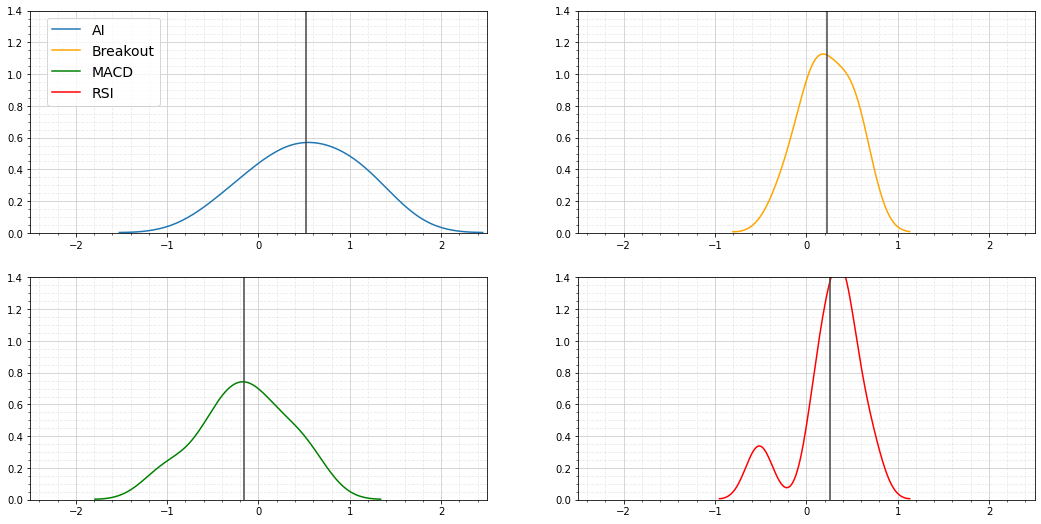

Anual Returns:


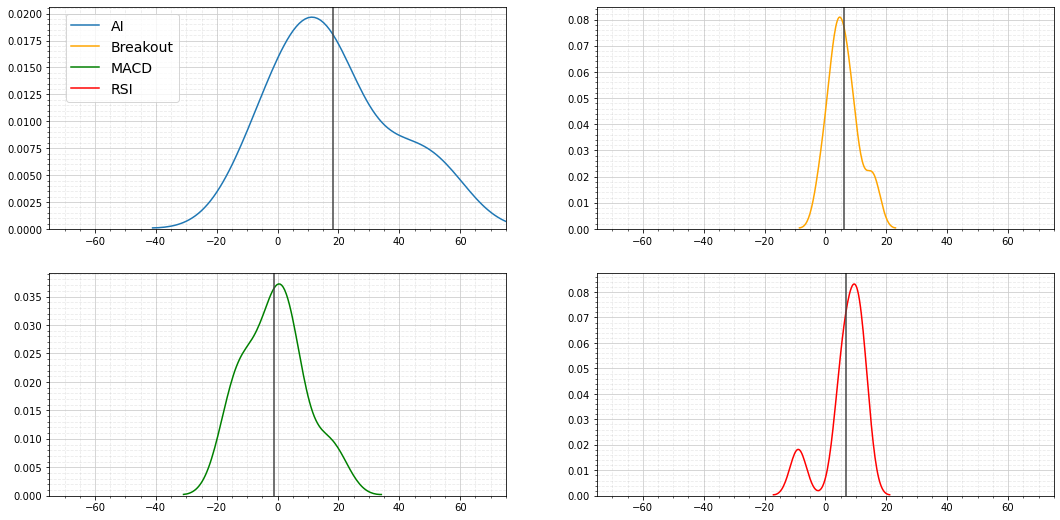

In [38]:
print("Sharp Ratio:")
plot_dis(ai_sr, break_sr, macd_sr, rsi_sr,1.4,2.5)
    
print("Anual Returns:")
plot_dis(ai_ret, break_ret, macd_ret, rsi_ret,None,75)

In [39]:
start_d = "2018-01-01"
end_d = "2019-01-01"

traders =  []
import time
#time.sleep(61)
print("Test1")
traders.append(TradeMaker("JPM",2, end_d,start_d,62, True))
print("Test2")
traders.append(TradeMaker("DAL",2, end_d,start_d,62, True))
print("Test3")
traders.append(TradeMaker("XOM",2, end_d,start_d,62, True))
print("Test4")
traders.append(TradeMaker("KR",2, end_d,start_d,62, True)) #x
print("Test5")
time.sleep(61)
traders.append(TradeMaker("EQIX",2, end_d,start_d,62, True)) #x
print("Test6")
traders.append(TradeMaker("NFLX",2, end_d,start_d,62, True)) #x
print("Test7")
traders.append(TradeMaker("NVDA",2,end_d,start_d,62, True)) #x
print("Test8")
traders.append(TradeMaker("JNJ",2, end_d,start_d,62, True)) 

Test1
Test2
Test3
Test4
Test5
Test6
Test7
Test8


In [40]:
ai_sr = []
ai_ret = []
break_sr = []
break_ret = []
macd_sr = []
macd_ret = []
rsi_sr = []
rsi_ret = []

for i in range(0, len(traders)):
    t = traders[i]
    t.data_manager.rescale(t.data_manager.unscaled_data[t.current_day]["close"]*2)

    print("")
    print("")
    print( "\"" + t.data_manager.stock_symbol + " AI:\"")
    tmp_data = ai(t)
    ai_sr.append(tmp_data[0])
    ai_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " Breakout:\"")
    tmp_data = breakout(t)
    break_sr.append(tmp_data[0])
    break_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " MACD:\"")
    tmp_data = macd(t)
    macd_sr.append(tmp_data[0])
    macd_ret.append(tmp_data[1]*100)
    print( "\"" + t.data_manager.stock_symbol + " RSI:\"")
    tmp_data = rsi(t)
    rsi_sr.append(tmp_data[0])
    rsi_ret.append(tmp_data[1]*100)
    




"JPM AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.6656518761115587";"-0.116733234895388";"3";"2"
"JPM Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.6506620534143795";"-0.028252578455538524";"0";"2"
"JPM MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-1.071338394527709";"-0.07159186526067729";"1";"4"
"JPM RSI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.10960346714399556";"0.039016240807385305";"1";"1"


"DAL AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.6768800653030377";"0.17342328381535377";"10";"2"
"DAL Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.5526672705918957";"-0.04088902873432765";"1";"3"
"DAL MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.8564303710541292";"0.12442580515183321";"3";"1"
"DAL RSI:"
"Sharp Ratio Strategy";"Anua

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:102: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.241569597863138";"-0.09175944962718563";"2";"0"
"NFLX Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.41124661102648186";"0.07900859280010342";"1";"5"
"NFLX MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.706129776608405";"-0.17707945362373678";"1";"1"
"NFLX RSI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.3316848421755653";"-0.10069608698142163";"0";"0"


"NVDA AI:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.7256880494101116";"-0.3483050215362291";"6";"3"
"NVDA Breakout:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-1.617912782057898";"-0.15180319417398358";"0";"6"
"NVDA MACD:"
"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.7642487877028465";"-0.1565825123938024";"2";"1"
"NVDA RSI:"
"Sharp Ratio Strategy";"Anual retu

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

<Figure size 1296x648 with 0 Axes>

Sharp Ratio:


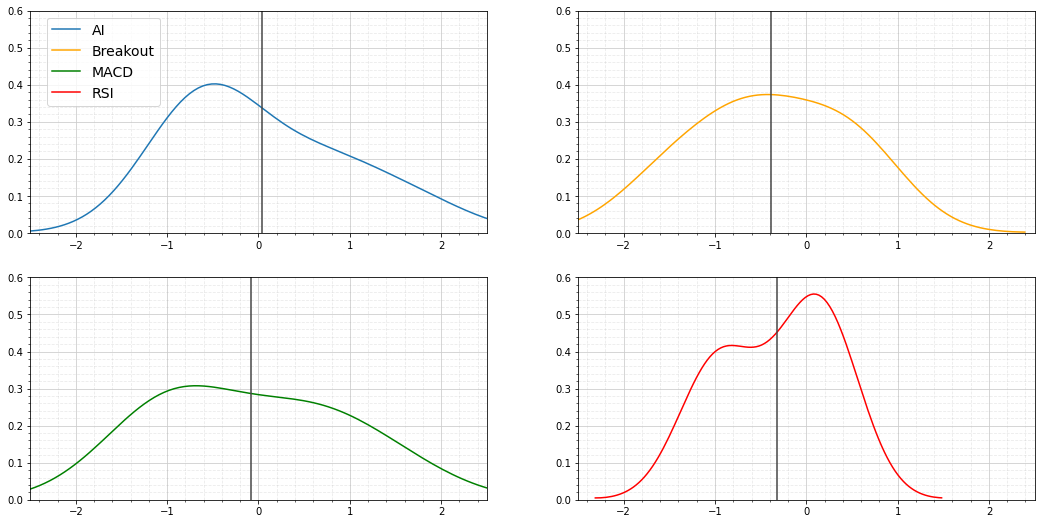

Anual Returns:


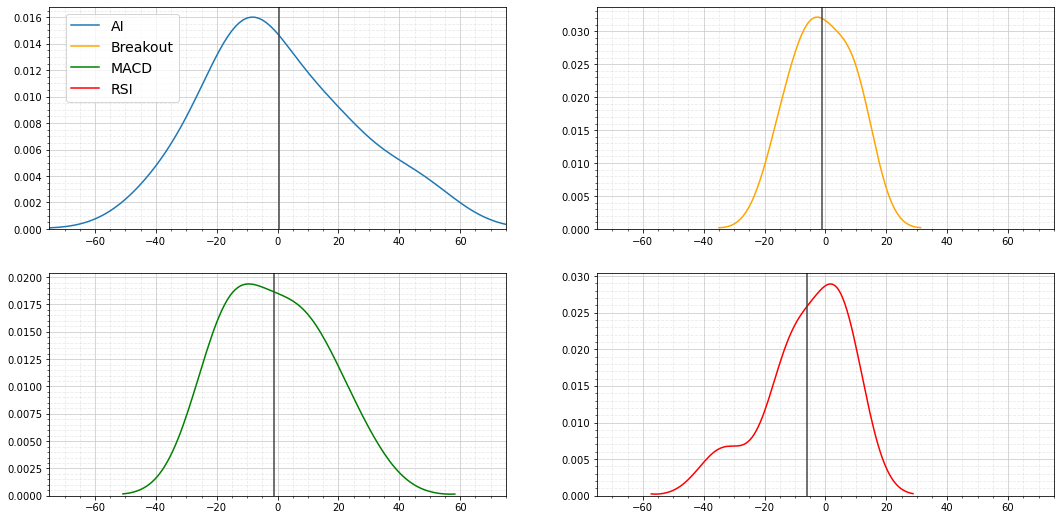

In [41]:
print("Sharp Ratio:")
plot_dis(ai_sr, break_sr, macd_sr, rsi_sr,0.6,2.5)
    
print("Anual Returns:")
plot_dis(ai_ret, break_ret, macd_ret, rsi_ret,None,75)

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5068270020892093";"0.1062270879742766";"18";"10"


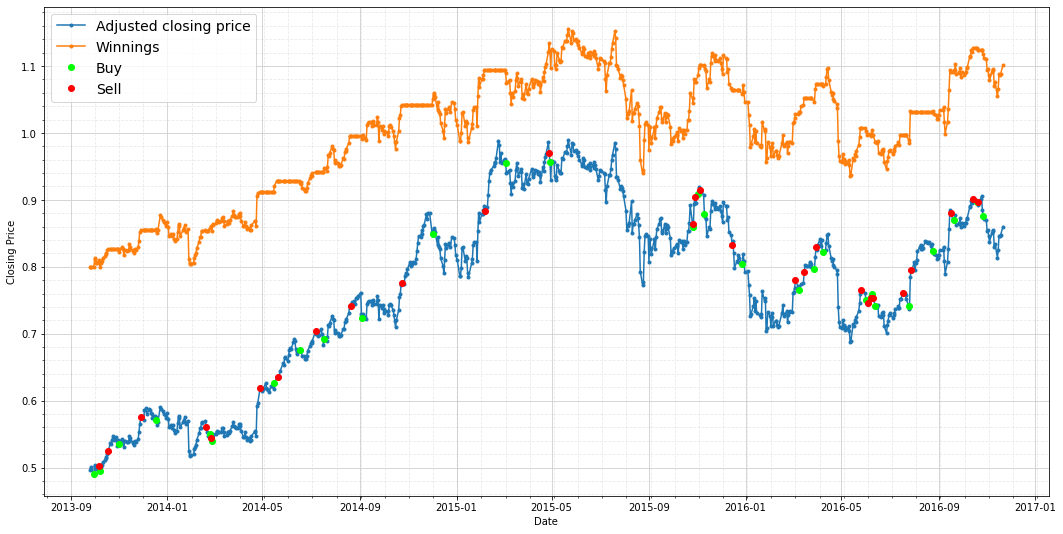

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"1.1790875529545448";"0.5711825515610822";"39";"23"


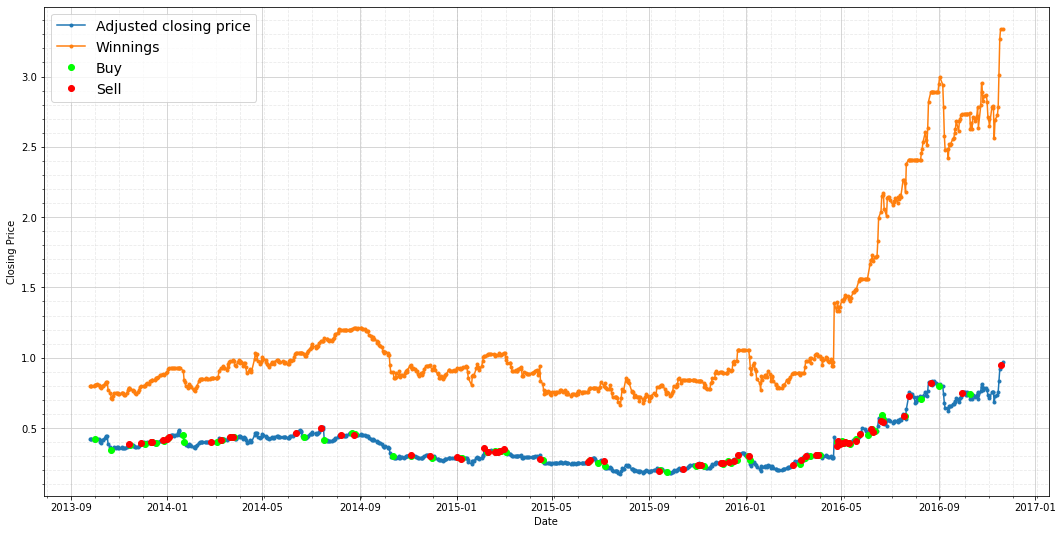

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.16535183272378537";"-0.08628861620680717";"18";"15"


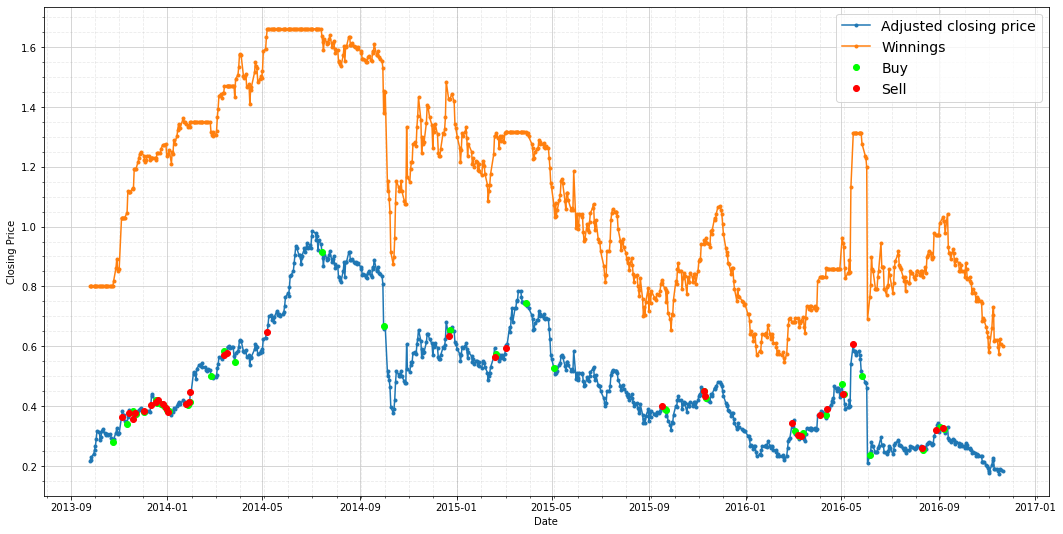

[-0.16535183272378537, -0.08628861620680717]

In [46]:
stevie = keras.models.load_model("./steavie_test.huber.bad")
v_trader_aapl = TradeMaker("AAPL",0.8,"2016-11-21", "2013-06-27",62, True)
v_trader_amd = TradeMaker("AMD",0.8,"2016-11-21", "2013-06-27",62, True)
v_trader_gsat = TradeMaker("GSAT",0.8,"2016-11-21", "2013-06-27",62, True)
validate(v_trader_aapl,stevie)
validate(v_trader_amd,stevie)
validate(v_trader_gsat,stevie)

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.7069250049254832";"0.13419668588050926";"14";"5"


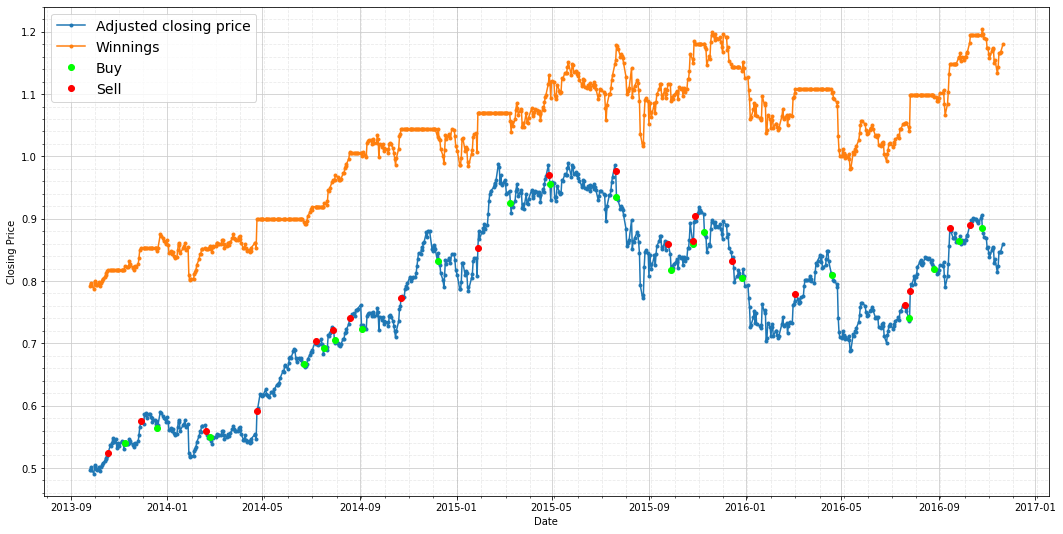

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"0.5175607976197909";"0.19961050010861214";"19";"4"


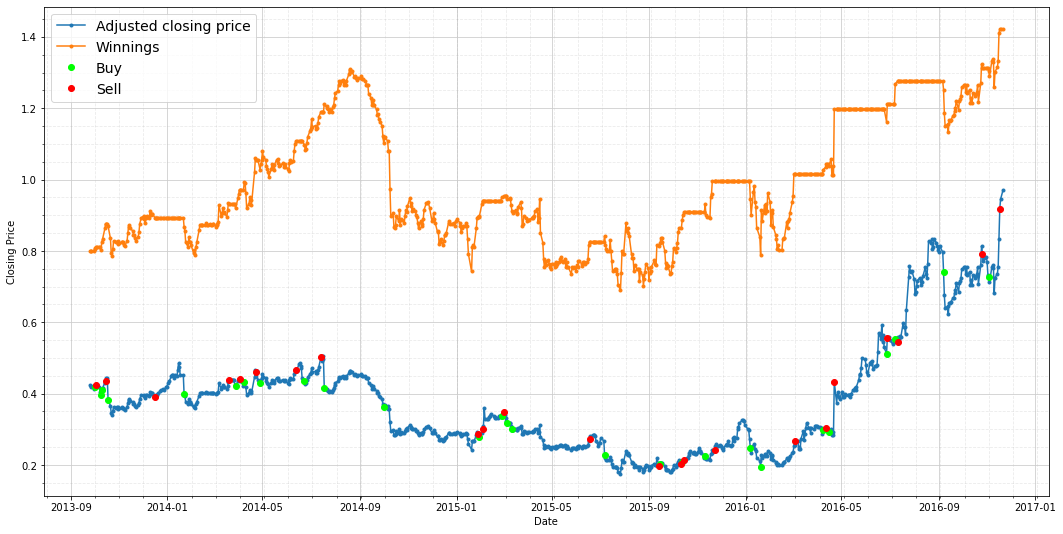

"Sharp Ratio Strategy";"Anual return";"Winning trades";"Loosing trades"
"-0.39196106983193435";"-0.1728144645996632";"16";"4"


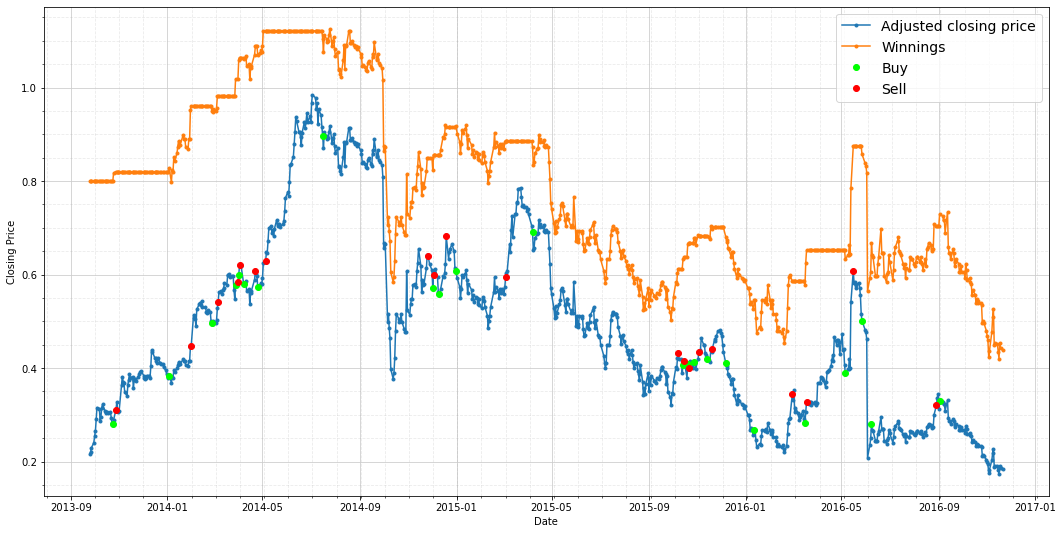

[-0.39196106983193435, -0.1728144645996632]

In [47]:
stevie = keras.models.load_model("./steavie.huber")
v_trader_aapl = TradeMaker("AAPL",0.8,"2016-11-21", "2013-06-27",62, True)
v_trader_amd = TradeMaker("AMD",0.8,"2016-11-21", "2013-06-27",62, True)
v_trader_gsat = TradeMaker("GSAT",0.8,"2016-11-21", "2013-06-27",62, True)
validate(v_trader_aapl,stevie)
validate(v_trader_amd,stevie)
validate(v_trader_gsat,stevie)